# Imports

In [1]:
# install additional packages if running on Emscripten
import platform

notebook_platform = platform.uname()
if notebook_platform.system == "Emscripten":
    import piplite

    await piplite.install(["openpyxl", "seaborn"])

In [2]:
from enum import Enum
import re
import pathlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

sns.set_style("ticks", {"axes.grid": True})

# Data

In [3]:
this_file = pathlib.Path().absolute()
data_dir = this_file.parent / "data"
data_dir

WindowsPath('c:/Users/Legion/workspace/tld_let_calibration/data')

## Monte-Carlo results

In [4]:
import json
from pathlib import Path
from dataclasses import dataclass
from typing import List
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
@dataclass
class Result1D:
    x_values: List[float]
    y_values: List[float]
    x_name: str
    y_name: str
    x_unit: str
    y_unit: str

    # shorter string representation, including length of data for x and y values
    def __repr__(self):
        return f"Result1D({self.x_name} ({len(self.x_values)}), {self.y_name} ({len(self.y_values)}))"

In [26]:
def list_of_estimators(json_filepath: Path) -> List[str]:
    estimators = []
    with open(json_filepath, "r") as f:
        bp_mc_data_sh12a = json.load(f)
        estimators = [estimator["name"] for estimator in bp_mc_data_sh12a["estimators"]]
    return estimators


def list_of_pages(json_filepath: Path, estimator_name: str) -> List[str]:
    pages = []
    with open(json_filepath) as f:
        bp_mc_data_sh12a = json.load(f)
        for estimator in bp_mc_data_sh12a["estimators"]:
            if estimator["name"] == estimator_name:
                pages = [page["name"] for page in estimator["pages"]]
    return pages


def get_data_1d(json_filepath: Path, estimator_name: str, page_name: str) -> Result1D:
    result = Result1D([], [], "", "", "", "")
    with open(json_filepath) as f:
        bp_mc_data_sh12a = json.load(f)
        for estimator in bp_mc_data_sh12a["estimators"]:
            if estimator["name"] == estimator_name:
                for page in estimator["pages"]:
                    if page["name"] == page_name:
                        result.x_values = page["axisDim1"]["values"]
                        result.y_values = page["data"]["values"]
                        result.x_name = page["axisDim1"]["name"]
                        result.y_name = page["data"]["name"]
                        result.x_unit = page["axisDim1"]["unit"]
                        result.y_unit = page["data"]["unit"]
    return result

In [35]:
bp_mc_data_file_sh12a = data_dir / "raw" / "ifj_calibration" / "results_bp.json"
bp_mc_data_file_sh12a

WindowsPath('c:/Users/Legion/workspace/tld_let_calibration/data/raw/ifj_calibration/results_bp.json')

In [36]:
bp_mc_data_file_sh12a.exists()

True

In [37]:
list_of_estimators(bp_mc_data_file_sh12a)

['z_profile',
 'yz_profile',
 'slab_at_0mm',
 'slab_at_15mm',
 'slab_at_27mm',
 'slab_at_28mm',
 'xy_profile_entry']

In [38]:
list_of_pages(bp_mc_data_file_sh12a, estimator_name="z_profile")

['Dose',
 'FluenceProtons',
 'FluencePrimaries',
 'FluenceSecondaryProtons',
 'KineticEnergyProtons',
 'KineticEnergyPrimaries',
 'KineticEnergySecondaryProtons',
 'BetaProtons',
 'BetaPrimaries',
 'KineticEnergyDoseSpectrum',
 'KineticEnergyFluenceSpectrum',
 'dLETProtons',
 'dLETPrimaries',
 'dLETAll',
 'tLETProtons',
 'tLETPrimaries',
 'tLETAll']

In [39]:
list_of_pages(bp_mc_data_file_sh12a, estimator_name="LET")

[]

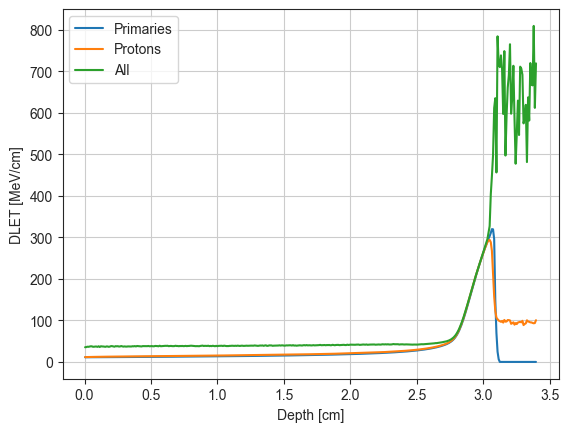

In [40]:
dLETPrimaries = get_data_1d(bp_mc_data_file_sh12a, estimator_name="z_profile", page_name="dLETPrimaries")
dLETProtons = get_data_1d(bp_mc_data_file_sh12a, estimator_name="z_profile", page_name="dLETProtons")
dLETAll = get_data_1d(bp_mc_data_file_sh12a, estimator_name="z_profile", page_name="dLETAll")

fig, ax = plt.subplots()
ax.plot(dLETPrimaries.x_values, dLETPrimaries.y_values, label="Primaries")
ax.plot(dLETProtons.x_values, dLETProtons.y_values, label="Protons")
ax.plot(dLETAll.x_values, dLETAll.y_values, label="All")
ax.set_xlabel(f"Depth [cm]")
ax.set_ylabel(f"{dLETPrimaries.y_name} [{dLETPrimaries.y_unit}]")
ax.grid(True)
ax.legend();

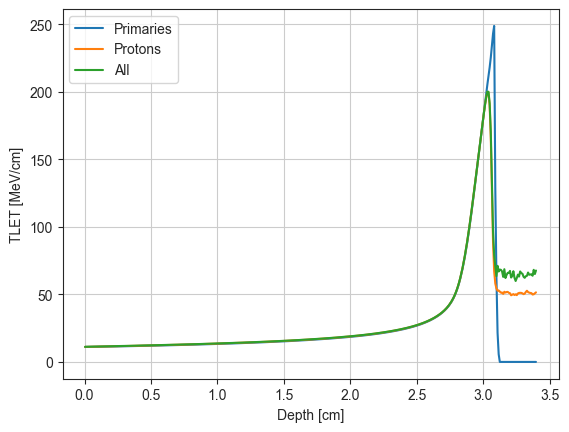

In [41]:
tLETPrimaries = get_data_1d(bp_mc_data_file_sh12a, estimator_name="z_profile", page_name="tLETPrimaries")
tLETProtons = get_data_1d(bp_mc_data_file_sh12a, estimator_name="z_profile", page_name="tLETProtons")
tLETAll = get_data_1d(bp_mc_data_file_sh12a, estimator_name="z_profile", page_name="tLETAll")

fig, ax = plt.subplots()
ax.plot(tLETPrimaries.x_values, tLETPrimaries.y_values, label="Primaries")
ax.plot(tLETProtons.x_values, tLETProtons.y_values, label="Protons")
ax.plot(tLETAll.x_values, tLETAll.y_values, label="All")
ax.set_xlabel(f"Depth [cm]")
ax.set_ylabel(f"{tLETPrimaries.y_name} [{tLETPrimaries.y_unit}]")
ax.grid(True)
ax.legend();

In [42]:
df = pd.DataFrame(
    {
        "dLETPrimaries": dLETPrimaries.y_values,
        "dLETProtons": dLETProtons.y_values,
        "dLETAll": dLETAll.y_values,
        "tLETPrimaries": tLETPrimaries.y_values,
        "tLETProtons": tLETProtons.y_values,
        "tLETAll": tLETAll.y_values,
    }
)
df.insert(0, "z_mm", dLETPrimaries.x_values)
df["z_mm"] = df.z_mm * 10
df

,z_mm,dLETPrimaries,dLETProtons,dLETAll,tLETPrimaries,tLETProtons,tLETAll
0,0.0425,11.227477,11.633363,35.385786,11.088739,11.119699,11.184843
1,0.1275,11.232338,11.724956,35.667142,11.088840,11.128653,11.201058
2,0.2125,11.234249,11.787788,36.679750,11.088901,11.135544,11.213373
3,0.2975,11.270811,11.869649,36.399744,11.128965,11.181241,11.259141
4,0.3825,11.277012,11.922945,37.028460,11.132754,11.190703,11.270034
...,...,...,...,...,...,...,...
395,33.6175,0.000000,95.157937,667.910476,0.000000,50.939122,64.914758
396,33.7025,0.000000,93.838051,666.153374,0.000000,49.928610,63.836474
397,33.7875,0.000000,93.075406,809.382192,0.000000,50.108000,68.220748
398,33.8725,0.000000,93.619083,611.994822,0.000000,50.774796,65.096386


In [43]:
df.to_csv(data_dir / "interim" / "mc.csv", index=False)

# Check data from CSV

In [44]:
df_mc = pd.read_csv(data_dir / "interim" / "mc.csv")
df_mc

,z_mm,dLETPrimaries,dLETProtons,dLETAll,tLETPrimaries,tLETProtons,tLETAll
0,0.0425,11.227477,11.633363,35.385786,11.088739,11.119699,11.184843
1,0.1275,11.232338,11.724956,35.667142,11.088840,11.128653,11.201058
2,0.2125,11.234249,11.787788,36.679750,11.088901,11.135544,11.213373
3,0.2975,11.270811,11.869649,36.399744,11.128965,11.181241,11.259141
4,0.3825,11.277012,11.922945,37.028460,11.132754,11.190703,11.270034
...,...,...,...,...,...,...,...
395,33.6175,0.000000,95.157937,667.910476,0.000000,50.939122,64.914758
396,33.7025,0.000000,93.838051,666.153374,0.000000,49.928610,63.836474
397,33.7875,0.000000,93.075406,809.382192,0.000000,50.108000,68.220748
398,33.8725,0.000000,93.619083,611.994822,0.000000,50.774796,65.096386


In [45]:
# Reshaping the DataFrame using melt
df_melted = pd.melt(df_mc, id_vars="z_mm", var_name="LET_Type", value_name="LET")
df_melted["averaging"] = df_melted["LET_Type"].apply(lambda x: x[0])
df_melted["particles"] = df_melted["LET_Type"].apply(lambda x: x[4:])
df_melted = df_melted.drop(columns="LET_Type")
df_melted

,z_mm,LET,averaging,particles
0,0.0425,11.227477,d,Primaries
1,0.1275,11.232338,d,Primaries
2,0.2125,11.234249,d,Primaries
3,0.2975,11.270811,d,Primaries
4,0.3825,11.277012,d,Primaries
...,...,...,...,...
2395,33.6175,64.914758,t,All
2396,33.7025,63.836474,t,All
2397,33.7875,68.220748,t,All
2398,33.8725,65.096386,t,All


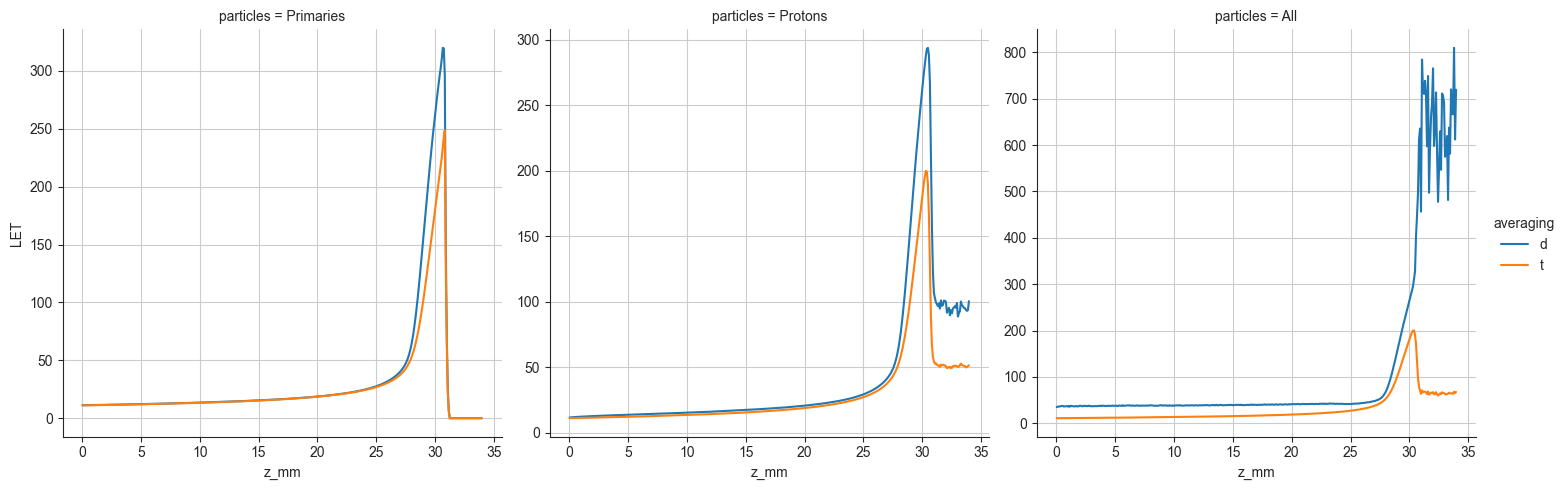

In [46]:
sns.relplot(
    data=df_melted, x="z_mm", y="LET", hue="averaging", col="particles", kind="line", facet_kws=dict(sharey=False)
)

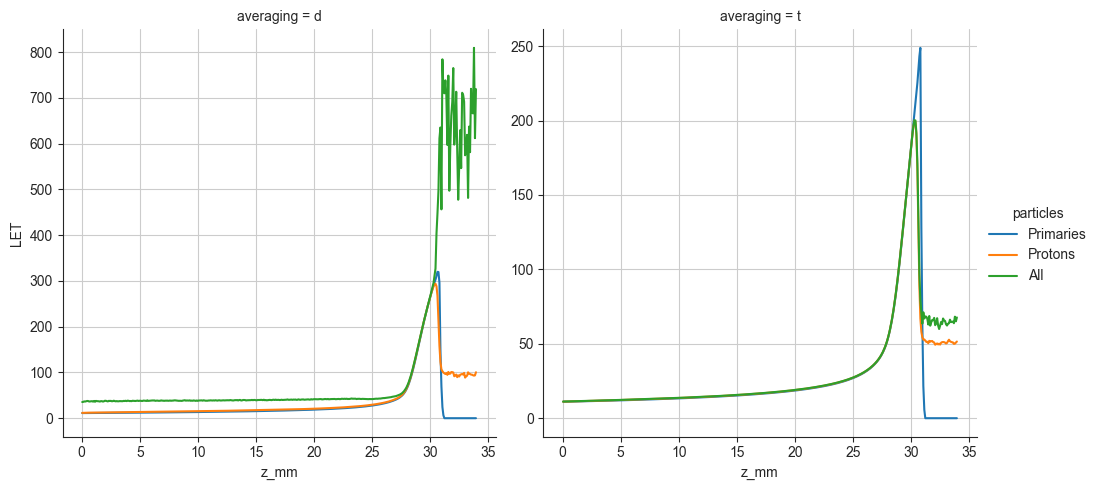

In [47]:
sns.relplot(
    data=df_melted, x="z_mm", y="LET", hue="particles", col="averaging", kind="line", facet_kws=dict(sharey=False)
)